In [1]:
import json
import requests
import pandas as pd
import os

# city_bikes.ipynb notebook 1 - Questions in steps.

## Question-1: Send a request to CityBikes for the city of your choice.
### Use Citybikes first endpoint to find whether data for particular city exists.

citybikes_url = "https://api.citybik.es/v2/networks"
response = requests.get(citybikes_url)
citybikedata = response.json()

city_name = "cork"  # Replace with the desired city name
city_id = None
for network in citybikedata['networks']:
    if city_name.lower() in network['location']['city'].lower():
        city_id = network['id']
        break

if city_id is None:
    print(f"No data found for {city_name}")
    exit()
    
## Question-2: Parse through the response to get the details you want for the bike stations in that city (latitude, longitude, number of bikes).  
### Use Citybikes second endpoint.

city_stations_url = f"https://api.citybik.es/v2/networks/{city_id}"
response = requests.get(city_stations_url)
stations_data = response.json()

stations = stations_data['network']['stations']

new_stations = list()

for station in stations:
    name = station["name"]
    latitude = station["latitude"]
    longitude = station["longitude"]
    num_bikes = station["free_bikes"]
    empty_slots = station["empty_slots"]

    new_stations.append({"Station Name": name, "latitude": latitude, "longitude": longitude, "Num_Bikes": num_bikes, "Empty_slots": empty_slots})

In [2]:
## Question-3: Put your parsed results into a DataFrame.
df_stations = pd.DataFrame(new_stations)

print(df_stations)

## Convert dataframe to csv for better understanding of data.
df_stations.to_csv('citybikedata.csv', index=False)

            Station Name   latitude  longitude  Num_Bikes  Empty_slots
0              Gaol Walk  51.893604  -8.494174         12           13
1      Fitzgerald's Park  51.895553  -8.493413         11            4
2              Bandfield  51.895806  -8.489136          4           27
3            Dyke Parade  51.897185  -8.484585          6           13
4            Pope's Quay  51.901632  -8.477385         13            5
5         North Main St.  51.899747  -8.478440          9            6
6            Grattan St.  51.898474  -8.479780          8            2
7        Wandesford Quay  51.896492  -8.480040         12           13
8             Bishop St.  51.894688  -8.479027          6            9
9            Camden Quay  51.901054  -8.473342          8            9
10       Corn Market St.  51.900000  -8.477000         13            9
11           Lapp's Quay  51.898144  -8.465735          5           25
12      St. Patricks St.  51.898505  -8.472615         19            1
13    

In [3]:
#yelp_foursquare_EDA.ipynb notebook 2- Questions in steps.

import json
import requests
import pandas as pd
import os

##Question-1: Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice.

fsq_api_key = os.environ["fsq_api_key"]

foursqr_headers = {
    "accept": "application/json",
    "Authorization": fsq_api_key
}

fsq_data = []

for each_station in new_stations:
    url = f"https://api.foursquare.com/v3/places/search?ll={each_station['latitude']},{each_station['longitude']}&radius=100000&categories=10000%2C13000&fields=geocodes%2Cname%2Clocation%2Ccategories%2Cdistance%2Crating"
    response = requests.get(url, headers=foursqr_headers)
    fsq_results = response.json()["results"]
    
## Question-2: Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc).

    all_fsq_pois = list()
    for each_poi in fsq_results:
      categories = list()
      for category in each_poi['categories']:
        categories.append(category['name'])
      poi_data =  {"POI Name": each_poi['name'], "Full POI Location": each_poi['location'], "Categories" : categories, "Rating": each_poi['rating'],  "Coordinates": each_poi['geocodes']['main'],  "Distance from station": each_poi['distance']}   
      all_fsq_pois.append(poi_data)
        
    ## Convert to dataframe for later use:
    df_fsq_pois = pd.DataFrame(all_fsq_pois)    
        
    ## Extract the "Distance from station" values from all_fsq_pois
    distances = [poi["Distance from station"] for poi in all_fsq_pois]

    ## Find the lowest integer value
    lowest_distance = min(distances)

    ## Create final fsq data file
    fsq_data.append({"Station Name": each_station["Station Name"], "latitude": each_station["latitude"], "longitude": each_station["longitude"], "Num_Bikes": each_station["Num_Bikes"], "Empty_slots": each_station["Empty_slots"], 'Foursquare POIS data': all_fsq_pois, "Shortest FSQ Distance from Station": lowest_distance})

In [4]:
## Question-3: Put your parsed results into a DataFrame.

df_all_fsq_pois = pd.DataFrame(fsq_data)  
print('THIS IS FOURSQUARE DATA EXTRACTED OUT ON BASIS OF CITYBIK DATA') 
print(df_all_fsq_pois)

## Convert dataframe to csv for better understanding of data.
df_all_fsq_pois.to_csv('fsqdata.csv', index=False)

THIS IS FOURSQUARE DATA EXTRACTED OUT ON BASIS OF CITYBIK DATA
            Station Name   latitude  longitude  Num_Bikes  Empty_slots  \
0              Gaol Walk  51.893604  -8.494174         12           13   
1      Fitzgerald's Park  51.895553  -8.493413         11            4   
2              Bandfield  51.895806  -8.489136          4           27   
3            Dyke Parade  51.897185  -8.484585          6           13   
4            Pope's Quay  51.901632  -8.477385         13            5   
5         North Main St.  51.899747  -8.478440          9            6   
6            Grattan St.  51.898474  -8.479780          8            2   
7        Wandesford Quay  51.896492  -8.480040         12           13   
8             Bishop St.  51.894688  -8.479027          6            9   
9            Camden Quay  51.901054  -8.473342          8            9   
10       Corn Market St.  51.900000  -8.477000         13            9   
11           Lapp's Quay  51.898144  -8.465735   

In [6]:
## Question-4: Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice.

yelp_api_key = os.environ["yelp_api_key"]

yelp_header = {"Authorization": yelp_api_key,
              "accept": "application/json"}

yelp_data = []

for each_station in new_stations:
    url = f"https://api.yelp.com/v3/businesses/search?latitude={each_station['latitude']}&longitude={each_station['longitude']}&radius=1000&categories=restaurant&categories=bar&categories=entertainment&sort_by=rating&limit=20"
    response = requests.get(url, headers=yelp_header)
    yelp_results = response.json()["businesses"]

## Question-5: Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc).
    all_yelp_pois = list()
    for each_poi in yelp_results:
      categories = list()
      for category in each_poi['categories']:
        categories.append(category['title'])
      poi_data =  {"Review_count": each_poi['review_count'], "POI Name": each_poi['name'], "Full POI Location": each_poi['location'], "Categories" : categories, "Rating": each_poi['rating'], "Coordinates": each_poi['coordinates'], "Distance from station": each_poi['distance'], "Is_business_closed": each_poi['is_closed']}   
      all_yelp_pois.append(poi_data)
      
    ##Convert to dataframe for later use:
    df_yelp_pois = pd.DataFrame(all_yelp_pois)
    
    ##Extract the "Distance from station" values from all_fsq_pois
    distances = [poi["Distance from station"] for poi in all_yelp_pois]

    ##Find the lowest integer value
    lowest_distance = min(distances)

    ##Add the lowest_distance to fsq_data
    yelp_data.append({"Station Name": each_station["Station Name"], "latitude": each_station["latitude"], "longitude": each_station["longitude"], "Num_Bikes": each_station["Num_Bikes"], "Empty_slots": each_station["Empty_slots"], 'Yelp POIS data': all_yelp_pois, "Shortest Yelp Distance from Station": lowest_distance})

In [8]:
## Question-6: Put your parsed results into a DataFrame.
df_all_yelp_pois = pd.DataFrame(yelp_data)  
print('THIS IS YELP DATA EXTRACTED OUT ON BASIS OF CITYBIK DATA') 
print(df_all_yelp_pois)

## Convert dataframe to csv for better understanding of data.
df_all_yelp_pois.to_csv('yelpdata.csv', index=False)

THIS IS YELP DATA EXTRACTED OUT ON BASIS OF CITYBIK DATA
            Station Name   latitude  longitude  Num_Bikes  Empty_slots  \
0              Gaol Walk  51.893604  -8.494174         12           13   
1      Fitzgerald's Park  51.895553  -8.493413         11            4   
2              Bandfield  51.895806  -8.489136          4           27   
3            Dyke Parade  51.897185  -8.484585          6           13   
4            Pope's Quay  51.901632  -8.477385         13            5   
5         North Main St.  51.899747  -8.478440          9            6   
6            Grattan St.  51.898474  -8.479780          8            2   
7        Wandesford Quay  51.896492  -8.480040         12           13   
8             Bishop St.  51.894688  -8.479027          6            9   
9            Camden Quay  51.901054  -8.473342          8            9   
10       Corn Market St.  51.900000  -8.477000         13            9   
11           Lapp's Quay  51.898144  -8.465735         

In [9]:
## Question-7: Which API provided you with more complete data? Provide an explanation.
# Clearly Yelp is better based on on the more rich information shown in above output, for example it is also telling me whether a POI is closed or not.
# Review count is another additional key in Yelp compared to FSQ.

## Question-8: Get the top 10 restaurants according to their rating.

### top 10 FourSquare restaurants

fsq_top_10_ratings = df_fsq_pois.sort_values(by="Rating", ascending=False).head(10)
print('FSQ top 10')
print(fsq_top_10_ratings[["Rating", "POI Name"]])

FSQ top 10
   Rating                POI Name
8     9.3  The Jameson Experience
0     9.2           Bierhouse The
1     9.0                   Sin E
2     8.8      Three Fools Coffee
3     8.6     Rising Sons Brewery
4     8.6     The Oliver Plunkett
5     8.6           SALT Wine Bar
6     8.6            L'Atitude 51
7     8.4             Gallagher's
9     8.2              Quay Co-op


In [10]:
### top 10 Yelp restaurants

yelp_top_10_ratings = df_yelp_pois.sort_values(by="Rating", ascending=False).head(10)
print('Yelp top 10')
print(yelp_top_10_ratings[["Rating", "POI Name"]])

Yelp top 10
   Rating                          POI Name
1     5.0                     BeanTown Café
2     5.0                    Lennox Chipper
0     4.5                   Bishopstown Bar
3     4.0                    Spice of India
4     4.0  Wilton Willow Chinese Restaurant
5     4.0            O'Briens Sandwich Café
6     4.0                          Zambrero
7     2.5                            Camile
8     2.0           Ramen Asian Street Food
9     2.0            Jaye Taylor Restaurant


In [11]:
# joining_data.ipynb notebook 3 - Questions in steps.

import json
import requests
import pandas as pd
import os

## Question-1: Join the data from Part 1 with the data from Part 2 to create a new dataframe.

## Drop duplicate columns from fsq data
fsq_columns_to_drop = ["latitude", "longitude", "Num_Bikes", "Empty_slots"]
df_all_fsq_pois_v2 = df_all_fsq_pois.drop(columns=fsq_columns_to_drop)

## Drop duplicate columns from yelp data
yelp_columns_to_drop = ["latitude", "longitude", "Num_Bikes", "Empty_slots"]
df_all_yelp_pois_v2 = df_all_yelp_pois.drop(columns=yelp_columns_to_drop)

## Merge the citybike, fsq and yelp data
merged_df_citybik_fsq = pd.merge(df_stations, df_all_fsq_pois_v2, on='Station Name', how='inner')
merged_df_citybik_fsq_yelp = pd.merge(merged_df_citybik_fsq, df_all_yelp_pois_v2, on='Station Name', how='inner')

print('\nTHIS IS CITYBIK, FOURSQUARE AND YELP DATA COMBINED') 
print(merged_df_citybik_fsq_yelp)

## Convert dataframe to csv for better understanding of data.
merged_df_citybik_fsq_yelp.to_csv('mergeddata.csv', index=False)


THIS IS CITYBIK, FOURSQUARE AND YELP DATA COMBINED
            Station Name   latitude  longitude  Num_Bikes  Empty_slots  \
0              Gaol Walk  51.893604  -8.494174         12           13   
1      Fitzgerald's Park  51.895553  -8.493413         11            4   
2              Bandfield  51.895806  -8.489136          4           27   
3            Dyke Parade  51.897185  -8.484585          6           13   
4            Pope's Quay  51.901632  -8.477385         13            5   
5         North Main St.  51.899747  -8.478440          9            6   
6            Grattan St.  51.898474  -8.479780          8            2   
7        Wandesford Quay  51.896492  -8.480040         12           13   
8             Bishop St.  51.894688  -8.479027          6            9   
9            Camden Quay  51.901054  -8.473342          8            9   
10       Corn Market St.  51.900000  -8.477000         13            9   
11           Lapp's Quay  51.898144  -8.465735          5   

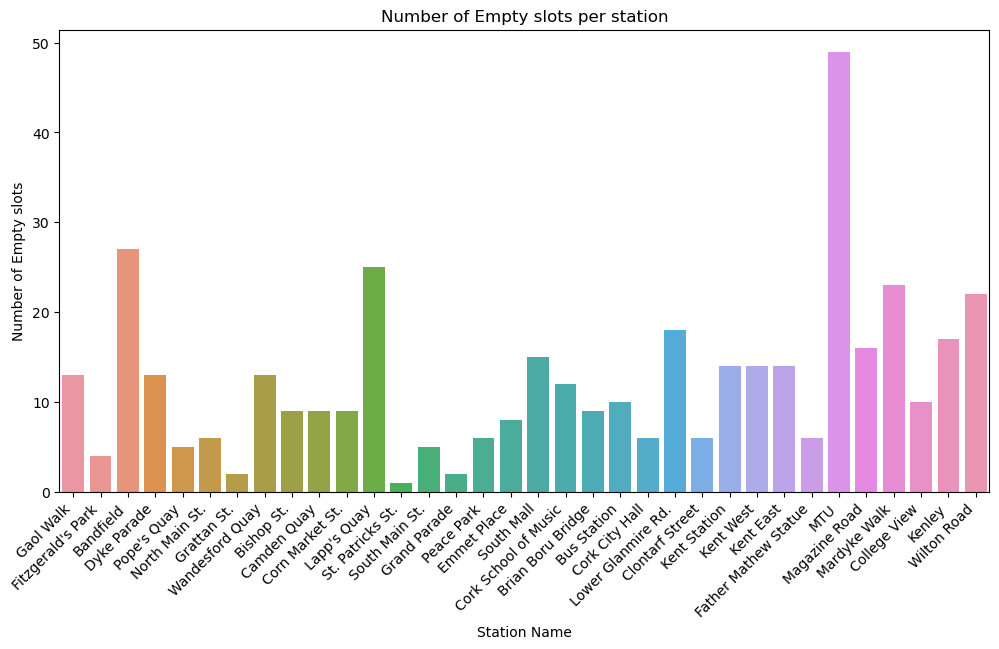

In [12]:
# Question-2: Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization.

import matplotlib.pyplot as plt
import seaborn as sns

## Convert "NA" values to NaN in the "Num_Bikes" column
merged_df_citybik_fsq_yelp["Empty_slots"] = pd.to_numeric(merged_df_citybik_fsq_yelp["Empty_slots"], errors="coerce")

## Filter out rows with non-numeric values in the "Num_Bikes" column
merged_df_citybik_fsq_yelp = merged_df_citybik_fsq_yelp.dropna(subset=["Empty_slots"])

## Bar Chart: Number of Bikes per Station
plt.figure(figsize=(12, 6))
sns.barplot(x="Station Name", y="Empty_slots", data=merged_df_citybik_fsq_yelp)
plt.title("Number of Empty slots per station")
plt.xlabel("Station Name")
plt.ylabel("Number of Empty slots")
plt.xticks(rotation=45, ha="right")
plt.show()

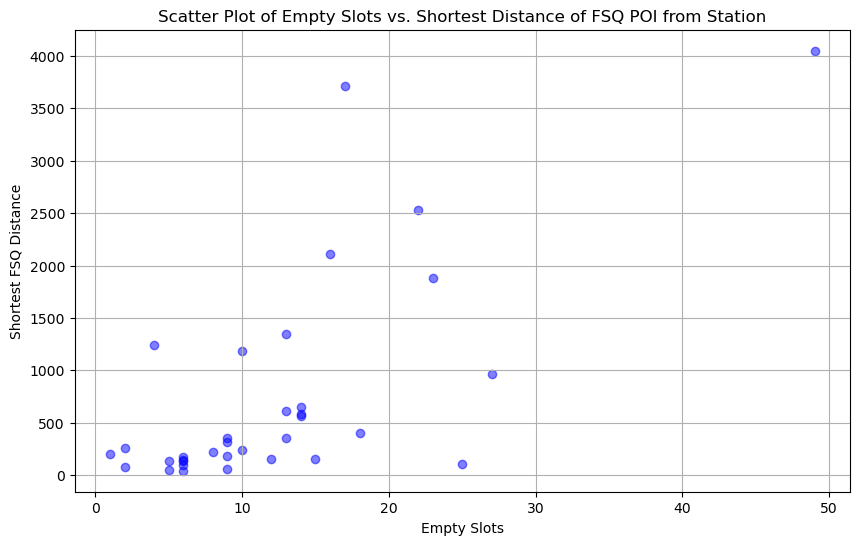

In [13]:
## Create a Scatter Plot of Empty Slots vs. Shortest FSQ Distance
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(
    merged_df_citybik_fsq_yelp["Empty_slots"],
    merged_df_citybik_fsq_yelp["Shortest FSQ Distance from Station"],
    alpha=0.5,  # Adjust the alpha for transparency
    color='b',  # Adjust the color
)

## Set axis labels and a title
plt.xlabel("Empty Slots")
plt.ylabel("Shortest FSQ Distance")
plt.title("Scatter Plot of Empty Slots vs. Shortest Distance of FSQ POI from Station")

## Show the plot
plt.grid(True)
plt.show()

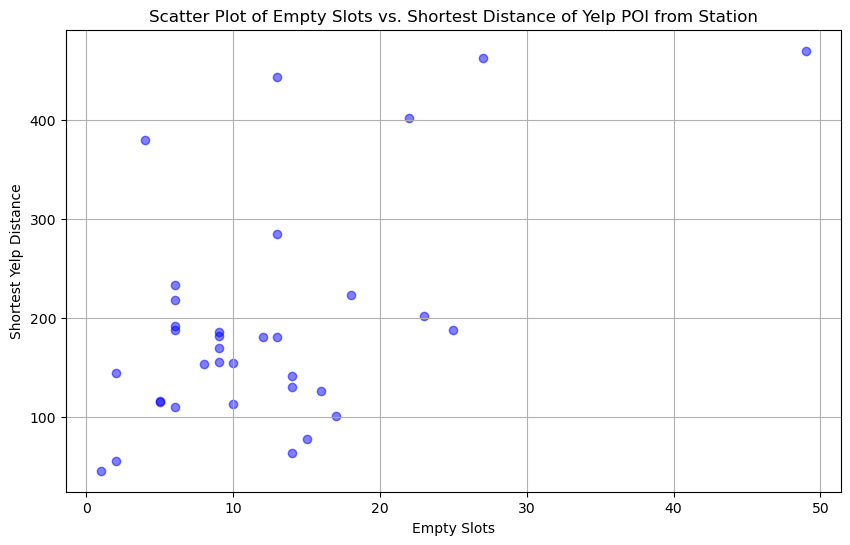

In [14]:
## Create a Scatter Plot of Empty Slots vs. Shortest Yelp Distance
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(
    merged_df_citybik_fsq_yelp["Empty_slots"],
    merged_df_citybik_fsq_yelp["Shortest Yelp Distance from Station"],
    alpha=0.5,  # Adjust the alpha for transparency
    color='b',  # Adjust the color
)

## Set axis labels and a title
plt.xlabel("Empty Slots")
plt.ylabel("Shortest Yelp Distance")
plt.title("Scatter Plot of Empty Slots vs. Shortest Distance of Yelp POI from Station")

## Show the plot
plt.grid(True)
plt.show()

In [15]:
# Question-3: Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

import sqlite3

## Function to convert lists to JSON-encoded strings
def list_to_json(lst):
    return json.dumps(lst)

## Create a connection to the SQLite database
conn = sqlite3.connect('db_df_citybik_fsq_yelp.db')

## Modify the DataFrames to store lists as JSON-encoded strings
df_all_fsq_pois['Foursquare POIS data'] = df_all_fsq_pois['Foursquare POIS data'].apply(list_to_json)
df_all_yelp_pois['Yelp POIS data'] = df_all_yelp_pois['Yelp POIS data'].apply(list_to_json)
merged_df_citybik_fsq_yelp['Foursquare POIS data'] = merged_df_citybik_fsq_yelp['Foursquare POIS data'].apply(list_to_json)
merged_df_citybik_fsq_yelp['Yelp POIS data'] = merged_df_citybik_fsq_yelp['Yelp POIS data'].apply(list_to_json)

## Convert citybike+fsq DataFrame to SQLite without specifying data types
df_all_fsq_pois.to_sql('table_df_citybik_fsq', conn, if_exists='replace', index=False)

## Convert citybike+yelp DataFrame to SQLite without specifying data types
df_all_yelp_pois.to_sql('table_df_citybik_yelp', conn, if_exists='replace', index=False)

## Convert Merged DataFrame to SQLite without specifying data types
merged_df_citybik_fsq_yelp.to_sql('table_merged_df_citybik_fsq_yelp', conn, if_exists='replace', index=False)

## Verify fsq table by reading from the database
query = "SELECT * FROM table_df_citybik_fsq LIMIT 5"
fsq_result = pd.read_sql_query(query, conn)
                           
## Verify by reading from the database
query = "SELECT * FROM table_df_citybik_yelp LIMIT 5"
yelp_result = pd.read_sql_query(query, conn)

## Verify by reading from the database
query = "SELECT * FROM table_merged_df_citybik_fsq_yelp LIMIT 5"
merged_result = pd.read_sql_query(query, conn)

## Close the database connection
conn.close()

                                
# Question-4: Look at the data before and after the join to validate your data.
## Print the table to verify
print(fsq_result)
print(yelp_result)
print(merged_result)

## Close the database connection
conn.close()

        Station Name   latitude  longitude  Num_Bikes  Empty_slots  \
0          Gaol Walk  51.893604  -8.494174         12           13   
1  Fitzgerald's Park  51.895553  -8.493413         11            4   
2          Bandfield  51.895806  -8.489136          4           27   
3        Dyke Parade  51.897185  -8.484585          6           13   
4        Pope's Quay  51.901632  -8.477385         13            5   

                                Foursquare POIS data  \
0  [{"POI Name": "Bierhouse The", "Full POI Locat...   
1  [{"POI Name": "Bierhouse The", "Full POI Locat...   
2  [{"POI Name": "Bierhouse The", "Full POI Locat...   
3  [{"POI Name": "Bierhouse The", "Full POI Locat...   
4  [{"POI Name": "Bierhouse The", "Full POI Locat...   

   Shortest FSQ Distance from Station  
0                                1348  
1                                1243  
2                                 962  
3                                 614  
4                                  48  
  

In [18]:
# model_building.ipynb notebook 4 - Questions in steps.

## Question-1: Build a regression model.

import pandas as pd
import statsmodels.api as sm

## Select relevant columns for modeling
selected_columns = [
    "Shortest Yelp Distance from Station",
    "Empty_slots"
]

## Create a subset of the DataFrame with the selected columns
data = merged_df_citybik_fsq_yelp[selected_columns]

## Data Preprocessing
### Make a copy of the data to avoid modifying the original DataFrame
data = data.copy()

### Check for missing values and drop rows with missing values
data.dropna(inplace=True)

## Split the data into independent variables (X) and the target variable (y)
X = data[["Shortest Yelp Distance from Station"]]
y = data["Empty_slots"]

## Add a constant term to the independent variables for the intercept
X = sm.add_constant(X)

## Create and train a linear regression model using statsmodels
model = sm.OLS(y, X).fit()

## Print a summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Empty_slots   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     14.28
Date:                Sun, 03 Sep 2023   Prob (F-statistic):           0.000649
Time:                        19:27:51   Log-Likelihood:                -116.99
No. Observations:                  34   AIC:                             238.0
Df Residuals:                      32   BIC:                             241.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

## Question-2: Build a regression model.Provide model output and an interpretation of the results.
### R-squared value of model is 0.309 which suggests that model explains a moderate amount of the variability in the data.
The adjusted R-squared (Adj. R²) is 0.287, which is slightly lower than R-squared. This might be due to overfitting or there might be other variables which can be explored to improve the fitting.
Also  with a p-value of 0.001, it can be deduced that the model is statistically significant and there is strong evidence to suggest that changes in the "Shortest Yelp Distance from Station" variable are associated with changes in the number of empty slots. 
In other words, the distance from the station is likely a significant predictor of the number of empty slots.


In [ ]:
## Question-3: How can you turn the regression model into a classification model?

### Define the classes
### Class 1: Low Availability (Empty_slots <= 5), Class 2: High Availability (Empty_slots > 5)
merged_df_citybik_fsq_yelp['Availability'] = (merged_df_citybik_fsq_yelp['Empty_slots'] <= 5).astype(int)

### Create a copy of the DataFrame to avoid the SettingWithCopyWarning
data = merged_df_citybik_fsq_yelp.copy()

### Select relevant columns for modeling
selected_columns = ["Shortest Yelp Distance from Station", "Availability"]
data = data[selected_columns]

### Data Preprocessing
data.dropna(inplace=True)

### Split the data into training and testing sets
X = data[["Shortest Yelp Distance from Station"]]
y = data["Availability"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

### Make predictions on the test set
y_pred = model.predict(X_test)

### Evaluate the classification model
accuracy = accuracy_score(y_test, y_pred)

### Set zero_division=1 to avoid UndefinedMetricWarning
classification_rep = classification_report(y_test, y_pred, zero_division=1)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

### Now use this trained classification model for prediction
### For example:
new_data = pd.DataFrame({
    "Shortest Yelp Distance from Station": [25]
})
predicted_class = model.predict(new_data)
print("Predicted Class:", predicted_class)